In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Resize

import matplotlib.pyplot as plt
import numpy as np

In [47]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(50,50))])

In [48]:
data_path = '/Users/nicolocampagnoli/Downloads/data1/'
flower_train = datasets.Flowers102(data_path,split= "test", download=True, transform=transform)
flower_test = datasets.Flowers102(data_path,split = "train", download=True, transform=transform)

#Switched test and train because their sizes seemed off

In [49]:
print("Training: ", len(flower_train))
print("Testing: ", len(flower_test))

Training:  6149
Testing:  1020


In [50]:
type(flower_train)

torchvision.datasets.flowers102.Flowers102

In [51]:
type(flower_test)

torchvision.datasets.flowers102.Flowers102

In [52]:
type(flower_train[0])

tuple

In [53]:
image, label = flower_train[0]
type(image)

torch.Tensor

In [54]:
image.shape

torch.Size([3, 50, 50])

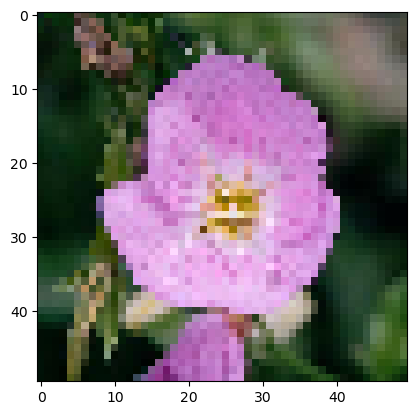

In [55]:
plt.imshow(image.permute(1, 2, 0))


In [56]:
torch.manual_seed(80)
train_loader = DataLoader(flower_train, batch_size=100, shuffle=True)
test_loader = DataLoader(flower_test, batch_size=500, shuffle=False)

In [57]:
class MultilayerPerceptron(nn.Module):

    def __init__(self, input_size=50*50*3, output_size=102, size=(50,50)):
        super().__init__()
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 2000)
        self.fc2 = nn.Linear(2000, 1000)
        self.fc3 = nn.Linear(1000, output_size)

    def forward(self, X):
        X = self.flat(X)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

In [58]:
torch.manual_seed(80)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=7500, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=102, bias=True)
)

In [59]:
for param in model.parameters():
  print(param.numel())

15000000
2000
2000000
1000
102000
102


In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [61]:

for images, labels in train_loader:
  
  break

In [62]:
import time
start_time = time.time()

epochs = 100

train_losses = []
test_losses = []
train_correct = []
test_correct  = []

for i in range(epochs):
   
    trn_corr = 0
    tst_corr = 0
    batch_corr = 0
    

    for b_iter, (X_train, y_train) in enumerate(train_loader):
      b_iter +=1

      y_pred = model(X_train)
      loss = criterion(y_pred, y_train)
      
      predicted = torch.max(y_pred.data, 1)[1]
      batch_corr = (predicted == y_train).sum()
      trn_corr += batch_corr
      
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if b_iter % 100 == 1:
        
        accuracy = trn_corr.item()*100 / (100*b_iter)
        print( f'epoch: {i} batch {b_iter} loss:{loss.item()} accuracy:{accuracy} ')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
      
      for b_iter, (X_test, y_test) in enumerate(test_loader):
        
        y_val = model(X_test)
        
        predicted = torch.max(y_val.data, 1)[1]
        tst_corr += (predicted == y_test).sum()
     
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print("Accuracy = {}".format(accuracy))

#No GPU because I run the code locally on my pc which doesn't support cuda

epoch: 0 batch 1 loss:4.627880096435547 accuracy:2.0 


KeyboardInterrupt: 

In [ ]:
train_accuracy =[t/500 for t in train_correct ] 
train_accuracy

In [ ]:
test_accuracy =[t/100 for t in test_correct ] 
test_accuracy

In [ ]:
test_load_all = DataLoader(flower_test, batch_size=10000, shuffle=False)

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_all: 
    y_val = model(X_test.view(len(X_test),-1))
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()

In [ ]:
100*correct.item()/len(flower_test)

In [ ]:
img = images[0].view(1, 7500)
 
with torch.no_grad():
    model_prediction = model.forward(img)

In [ ]:
probabilities = F.softmax(model_prediction, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
img = img.view(3, 50, 50)
ax1.imshow(img.permute(1, 2, 0).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(102), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()